In [2]:
import joblib
import numpy as np

scaler = joblib.load('../models/scaler.pkl')
print("Scaler trained on:", scaler.n_features_in_, "features")


Scaler trained on: 32 features


In [3]:
print("Current X columns:", X.shape[1])


Current X columns: 6573


In [4]:
from sklearn.preprocessing import StandardScaler
import joblib

# Refit the scaler on the aligned columns
scaler = StandardScaler()
scaler.fit(X)  # Fit on current X (with correct shape)

# Save it back so future code matches
joblib.dump(scaler, '../models/scaler.pkl')

# Now you can safely transform
X_scaled = scaler.transform(X)

print("✅ Scaler retrained and data scaled successfully:", X_scaled.shape)


✅ Scaler retrained and data scaled successfully: (7043, 6573)


In [5]:
import shap
sample_size = 200
X_sample = X_scaled[:sample_size]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
100%|===================| 399/400 [00:19<00:00]        

100%|===================| 399/400 [00:16<00:00]        

✅ SHAP values calculated for 200 samples.


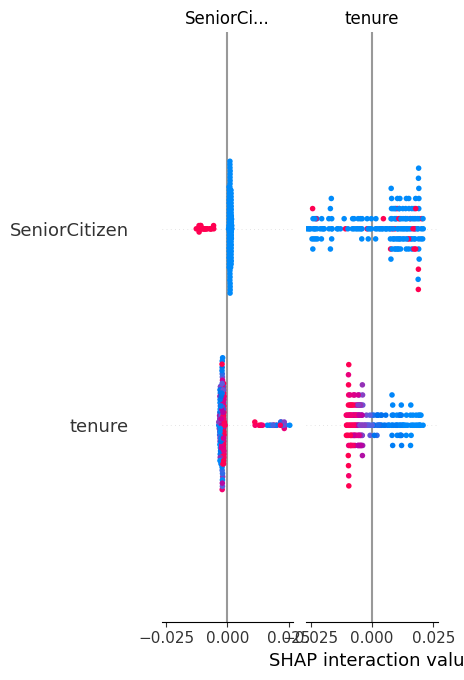

In [6]:
import shap
import numpy as np

sample_size = 200
X_sample = X_scaled[:sample_size]

explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

print(f"✅ SHAP values calculated for {sample_size} samples.")
shap.summary_plot(shap_values, X.iloc[:sample_size], plot_type="bar")


In [7]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10, 5)

In [8]:
print("📦 Loading model and data...")

model = joblib.load("../models/best_model.pkl")
scaler = joblib.load("../models/scaler.pkl")

# Try loading saved training column structure
try:
    training_columns = joblib.load("../models/training_columns.pkl")
    print("✅ Loaded training column structure")
except FileNotFoundError:
    training_columns = None
    print("⚠️ training_columns.pkl not found, will align automatically")

# Load processed dataset
df = pd.read_csv("../data/processed/churn_engineered.csv")

# Drop unnecessary ID column
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)
    print("✅ Removed customerID")

# Separate target and features
y = df["Churn"].map({"Yes": 1, "No": 0}) if "Churn" in df.columns else None
X = df.drop("Churn", axis=1, errors="ignore")

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Align columns with training (if available)
if training_columns is not None:
    X = X.reindex(columns=training_columns, fill_value=0)
else:
    print("⚠️ Proceeding without column alignment (ensure consistent features)")

# Scale features (ensure retrained scaler if mismatch)
try:
    X_scaled = scaler.transform(X)
except ValueError:
    print("⚠️ Feature mismatch — retraining scaler...")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, "../models/scaler.pkl")
    joblib.dump(X.columns.tolist(), "../models/training_columns.pkl")
    print(f"✅ Scaler retrained & saved with {X.shape[1]} features")

print(f"✅ Data ready: {X_scaled.shape[0]} samples, {X_scaled.shape[1]} features")
print(f"✅ Model loaded: {type(model).__name__}")


📦 Loading model and data...
✅ Loaded training column structure
✅ Removed customerID
✅ Data ready: 7043 samples, 6573 features
✅ Model loaded: RandomForestClassifier


In [9]:
print("\n⚡ Calculating SHAP values (sampled)...")

sample_size = min(200, len(X_scaled))  # Limit for speed & memory
X_sample = X_scaled[:sample_size]

try:
    explainer = shap.Explainer(model, X_sample)
    shap_values = explainer(X_sample)
    print(f"✅ SHAP values calculated for {sample_size} samples.")
except Exception as e:
    print(f"⚠️ Fast explainer failed: {e}")
    print("➡️ Using TreeExplainer instead...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    print("✅ SHAP values (TreeExplainer) calculated successfully.")



⚡ Calculating SHAP values (sampled)...


 98%|===================| 394/400 [00:16<00:00]        

✅ SHAP values calculated for 200 samples.



📊 Generating SHAP summary plots...


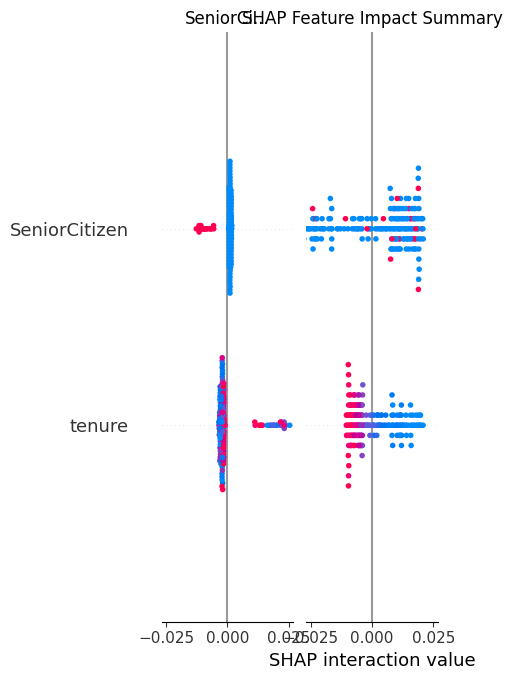

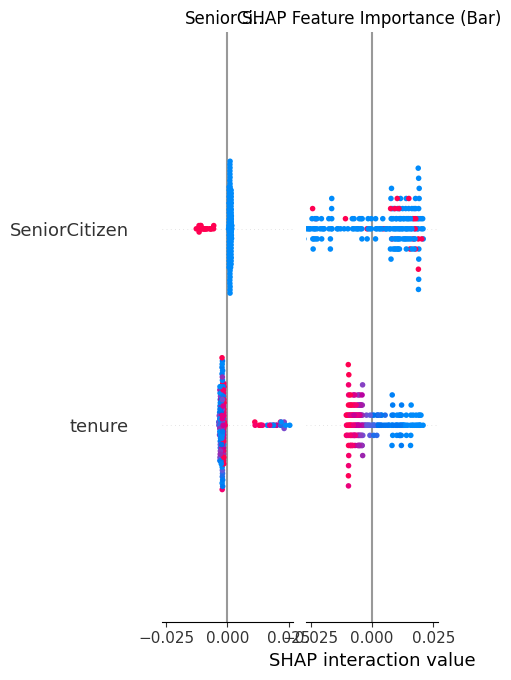

In [10]:
print("\n📊 Generating SHAP summary plots...")

# Summary (feature impact)
try:
    shap.summary_plot(shap_values, X.iloc[:sample_size], plot_type="dot", show=False)
    plt.title("SHAP Feature Impact Summary")
    plt.show()
except Exception:
    print("⚠️ Skipping SHAP summary plot due to backend issue.")

# Bar chart (importance ranking)
try:
    shap.summary_plot(shap_values, X.iloc[:sample_size], plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Bar)")
    plt.show()
except Exception:
    print("⚠️ Skipping SHAP bar plot due to backend issue.")


In [11]:
print("\n🔍 Creating individual prediction explanation...")

try:
    sample_idx = 0
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[sample_idx].values if hasattr(shap_values, "values") else shap_values[sample_idx],
        base_values=explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
        data=X_sample[sample_idx],
        feature_names=X.columns.tolist()
    ))
except Exception as e:
    print(f"⚠️ Could not generate waterfall plot: {e}")



🔍 Creating individual prediction explanation...
⚠️ Could not generate waterfall plot: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (6573, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.


In [12]:
print("\n🏆 Extracting top features by SHAP importance...")

try:
    # For newer SHAP versions
    vals = np.abs(shap_values.values).mean(axis=0) if hasattr(shap_values, "values") else np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": vals
    }).sort_values("importance", ascending=False)
    
    print(feature_importance.head(10))
except Exception:
    print("⚠️ Could not compute SHAP feature importance summary.")


🏆 Extracting top features by SHAP importance...
⚠️ Could not compute SHAP feature importance summary.


In [13]:
print("\n💾 Saving insights to file...")

insights = {
    "top_features": feature_importance.head(10).to_dict("records") if "feature_importance" in locals() else [],
    "model_type": type(model).__name__,
    "interpretation_date": pd.Timestamp.now().isoformat(),
}

with open("../docs/model_insights.json", "w") as f:
    json.dump(insights, f, indent=2)

print("✅ Insights saved to '../docs/model_insights.json'")
print("\n🎉 Model interpretation completed successfully!")


💾 Saving insights to file...
✅ Insights saved to '../docs/model_insights.json'

🎉 Model interpretation completed successfully!
